# Fitting Saturation-based Simulation Data With an Additional Forward Loss
Can having an additional loss from a forward model improve overfitting? 

The forward model is trained on the same data(Which now seems a bit questionable to me). It takes the predicted TMPs(In this case, scaled using the standard scaler, so don't need to worry about that part) and uses that to generate curve fitting parameters for both wavelength. The idea is to have this forward model **frozen** and then predict the probable curve fitting parameters using the prediction of the reverse model. Then take the difference between this and the original curve fitting parameters fed to the reverse model and calculate a loss term. This loss term is then added on to the original loss term.

# Comments
## Using Curve Fitting Parameters directly to predict TMPs
This idea did not pan out. Even though the curve fitting parameter percentage errors were small, it still mangled the resultant curves. I would see the slightest change in these parameters make the curve go upwards with SDD. Srcrping the whole fitting parameter idea for now

## Forward Model to Predict SI
Cannot figure out Fetal parameters. Predicts the mean. but atleast it does not overfit!

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBN, PerceptronDO, PerceptronBD
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity, create_curve_fitting_param
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc3.pkl'

data = pd.read_pickle(DATA_PATH)
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
# data = interpolate_exp(data, weights=[1, 0.7])
# data['Intensity'] = data['Interpolated Intensity']
# data = data.drop(columns='Interpolated Intensity')


data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log

data, x_columns, labels = create_spatial_intensity(data)
# data, x_columns, labels = create_ratio(data, True)
# data, x_columns, labels = create_spatial_intensity(data)
# data, x_columns, labels = create_curve_fitting_param(data, (1.0, 0.8))

data.head() 
# NOTE: Have only 1 on at the same time!

# Cleanup
data.dropna(inplace=True)

# Load Forward Model

In [3]:
# # Load Model Code
import joblib

# TODO: Change the forward model definition. I corrupted the old files - check forward_model_pairwise.ipynb

model_name = 'forward_curve_fit_paramv2'
fwd_model = PerceptronBD([5, 4, 8, 16, 40], dropout_rates = [0.01, 0.1, 0.1, 0.1])
fwd_model.load_state_dict(torch.load(rf'../models/{model_name}'))
fwd_model.eval()
# The input TMPs will already be scaled. No need to further use an x_scaler
y_scaler_fwd = joblib.load(rf'../models/{model_name}_yscaler')
x_scaler_fwd = joblib.load(rf'../models/{model_name}_xscaler')

class FwdModel:
    """
    Given a set of TMPs generate the spatial intensities.
    (The input and output scaling is considered to be equal, so no scaling is done. But in a 
    non-ideal world, you would expect a pair of scalers the input and one for output)
    Make sure the input TMPs are given in the same order as [x_columns]
    """
    x_columns = ['Maternal Wall Thickness', 'Maternal Hb Concentration', "Maternal Saturation", 
             "Fetal Hb Concentration", "Fetal Saturation"]
    
    
    def __init__(self, fwd_model: nn.Module) -> None:
        self.fwd_model = fwd_model
        self._prep_model()
        
    def _prep_model(self):
        # Send to CUDA
        self.fwd_model = self.fwd_model.cuda()
        # Set model to Eval mode (Disables Dropout layers)
        self.fwd_model = self.fwd_model.eval()
        # Freeze all layers
        # for param in self.fwd_model.parameters():
        #     param.requires_grad = False
    
    def forward(self, x: torch.Tensor):
        return self.fwd_model(x.cuda())


RuntimeError: Error(s) in loading state_dict for PerceptronBD:
	Missing key(s) in state_dict: "model.9.weight", "model.9.bias", "model.9.running_mean", "model.9.running_var", "model.12.weight", "model.12.bias". 
	size mismatch for model.0.weight: copying a param with shape torch.Size([10, 6]) from checkpoint, the shape in current model is torch.Size([4, 5]).
	size mismatch for model.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.1.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.1.running_mean: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.1.running_var: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for model.4.weight: copying a param with shape torch.Size([20, 10]) from checkpoint, the shape in current model is torch.Size([8, 4]).
	size mismatch for model.4.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for model.5.weight: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for model.5.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for model.5.running_mean: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for model.5.running_var: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for model.8.weight: copying a param with shape torch.Size([80, 20]) from checkpoint, the shape in current model is torch.Size([16, 8]).
	size mismatch for model.8.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([16]).

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [25]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Fetal Saturation']
# y_columns = ['Maternal Wall Thickness', 'Maternal Hb Concentration', "Maternal Saturation", 
            #  "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Hb Concentration']
# y_columns = ['Fetal Saturation']
# y_columns = ['Fetal Hb Concentration']
y_columns = FwdModel.x_columns      # Forward Models inputs are the Inverse Model's outputs

## X -> Predictors
# TODO: Maybe return these columns from the build_feature functions? have a single source of truth
ratio_columns = list(filter(lambda X: X.isdigit(), data.columns))   # Can be empty 
intensity_columns = list(filter(lambda X: '_' in X, data.columns))  # Can be empty 
x_columns = ratio_columns + intensity_columns

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# Defining Forward Model Loss

In [26]:

class CombinedLoss(nn.Module):
    """Calculates a combined reconstruction and inverse loss. The reconstruction loss is an MSE of 
    SI by a Forward model using TMPs predicted by the inverse model. The inverse loss is 
    the MSE from the ground truth TMPs. 
    
    The loss always assumes the TMPs are placed in the first n columns followed by all the SI's. *Do not break this 
    ordering*
    """
    def __init__(self, loaded_forward_model: nn.Module, tmp_count: int,
                inverse_loss_weight: float) -> None:
        super().__init__()
        self.fwd = FwdModel(loaded_forward_model)
        self.tmp_count = tmp_count
        self.mse_loss_recon = nn.MSELoss()
        self.mse_loss_inv = nn.MSELoss()
        self.inverse_loss_weight = inverse_loss_weight

    
    def forward(self, predicted_tmps, targets):
        tmp_taget = targets[:, :self.tmp_count]
        si_target = targets[:, self.tmp_count:]
        predicted_si = self.fwd.forward(predicted_tmps)
        reconstruction_loss = self.mse_loss_inv(predicted_si, si_target)
        inverse_loss = self.mse_loss_inv(predicted_tmps, tmp_taget)
        return (1 - self.inverse_loss_weight) * reconstruction_loss + self.inverse_loss_weight * inverse_loss

## Model Configuration

In [27]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns + intensity_columns, # Pass in both the Ground Truth TMP + SI to Custom Loss
    # Same Validation Method as the Forward Training Model : i.e. the same set is always held out
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data["Maternal Wall Thickness"].unique()[4])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}
loss = CombinedLoss(fwd_model, len(y_columns), 0.5)
# trainer_factory = ModelTrainerFactory(PerceptronReLU, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronBN, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronDO, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 5, OUT_FEATURES], 'dropout_rates': [0.01, 0.01, 0.01]}, generate_data_loaders, datagen_kw, 100, loss)

## Hyper Parameter Tuning

In [28]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [29]:
# # Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-4, 1e-2),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.9, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"],
#                        parameter_columns=["lr", "momentum"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

# best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [30]:
# best_trial.config

## Custom Training

In [31]:
set_seed(42)
trainer = trainer_factory.create()
# trainer.change_batch_size(16)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 6e-3, 'momentum': 0.96})
trainer.epochs = 100
trainer.run()

In [32]:
# trainer.epochs = 50
# trainer.run()

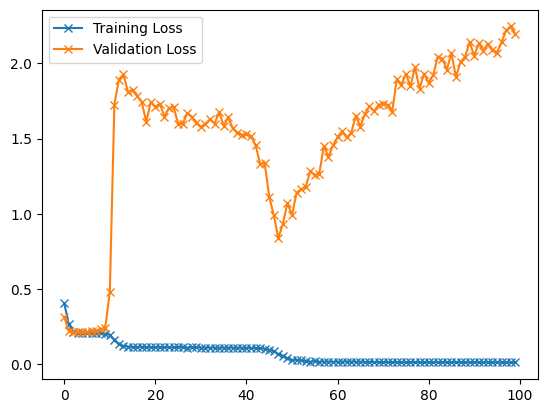

In [33]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [34]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.01, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=5, bias=True)
    (5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.01, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=5, bias=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0.96
    nesterov: False
    weight_decay: 0
)
        DataLoader Params: 
            Batch Size: 64
            Validation Method: Holds out fMaternal Wall Thickness columns 0.8783100656536799 for validation. The rest are used           

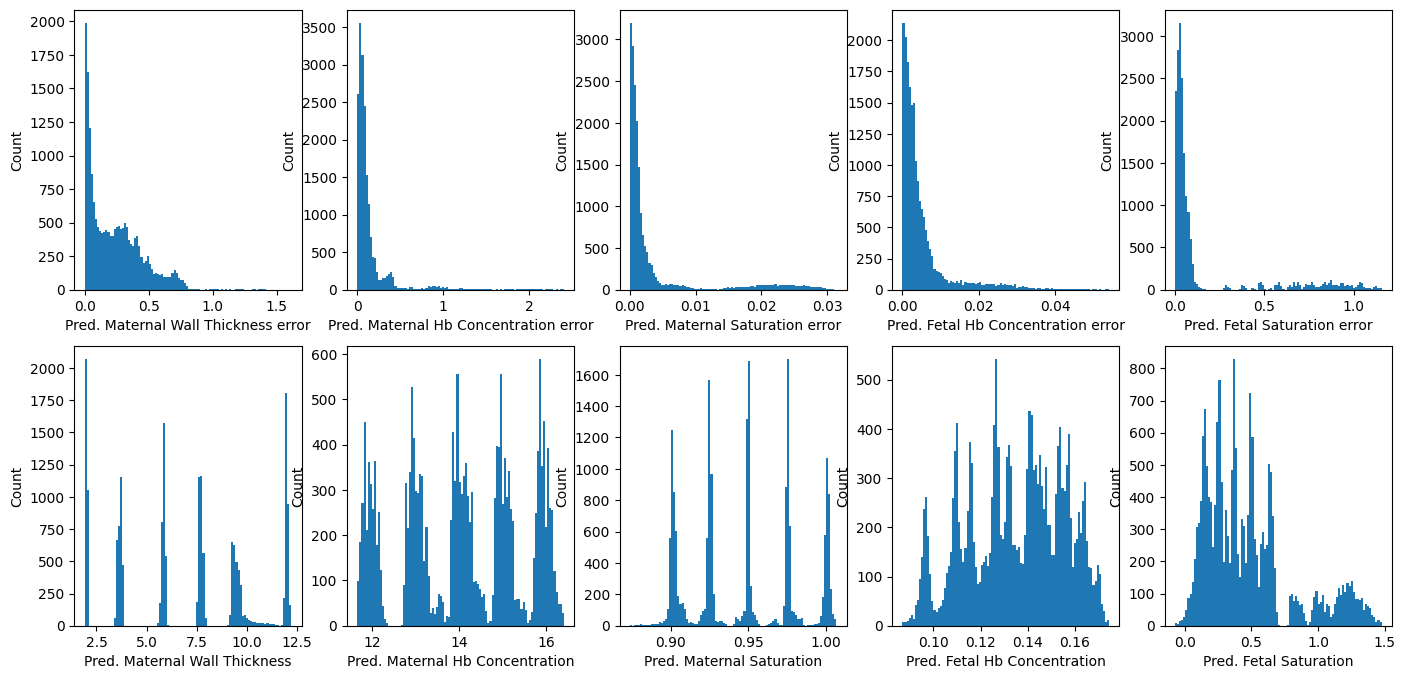

In [35]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = trainer.model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data)

    absolute_error = np.abs(y_data - predictions)
    error_df1 = pd.DataFrame({y_columns[i] + ' error': absolute_error[:, i] for i in range(len(y_columns))})
    error_df2 = pd.DataFrame({y_columns[i]: predictions[:, i] for i in range(len(y_columns))})
    error_df = pd.DataFrame(np.column_stack([error_df1, error_df2]), columns=error_df1.columns.append(error_df2.columns))
fig, axes = plt.subplots(2, 5, squeeze=True, figsize=(17, 8))
for i in range(len(error_df.columns)):
    error_column = error_df.columns[i]
    ax = axes.flatten()[i]
    plt.sca(ax)
    error_df[error_column].plot.hist(bins=100)
    # plt.xlabel(f'Abs. {error_column} Error')
    plt.xlabel(f'Pred. {error_column}')
    plt.ylabel('Count')
# plt.xlabel("Abs. Error")
plt.show()

In [36]:
# # Top Bad Samples
# VIEW_TOP_N = 50
# worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# # worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
# combined_table = data.join(error_df)
# with pd.option_context("display.max_rows", None):
#     display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [37]:
# # Rough MSE's in percentage
# print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
# print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [38]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,220
│    └─BatchNorm1d: 2-2                  40
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       105
│    └─BatchNorm1d: 2-6                  10
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       30
│    └─Flatten: 2-10                     --
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0

In [39]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [40]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')